In [52]:
import pandas as pd
import pathlib
import skimage
from skimage import filters, morphology, measure, feature, color
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

In [53]:
root = '/Users/kenxiong/Documents/BMI260/Final Project/data'
tif_paths = pathlib.Path(root).glob('**/*.tif')

columns = ['Age', 'Sex', 'Animal ID', 'Sequence ID', 'File Path']
data = []
for path in tif_paths:
    blob_data = []
    path_parts = str(path).split(r'/')
    age = path_parts[-3].split('_')[0][:-1]
    sex = path_parts[-3].split('_')[-1]
    animal_id = path_parts[-2].split('-')[1]
    seq_id = path_parts[-1].split('-')[-2]
    data.append([age, sex, animal_id, seq_id, path])
df = pd.DataFrame(data, columns=columns)

In [65]:
geo_features = ['area',
               'bbox_area',
               'convex_area',
               'eccentricity',
               'equivalent_diameter',
               'euler_number',
               'extent',
               'filled_area',
               'major_axis_length',
               'max_intensity',
               'mean_intensity',
               'min_intensity',
               'minor_axis_length',
               'orientation',
               'perimeter',
               'solidity',]

tex_features = ['contrast',
                'energy',
                'homogeneity',
                'correlation',
                'dissimilarity']

def min_max_normalize(i):
    return (i - np.min(i)) / (np.max(i) - np.min(i))

def get_section_features(img, geo_features, tex_features, demo=False):
    im = Image.open(img)
    im_hed = color.rgb2hed(im)
    im_hem = min_max_normalize(im_hed[:, :, 0])
    blurred = filters.gaussian(im_hem)
    thresh = filters.threshold_otsu(blurred)
    binary = blurred > thresh
    dilated = morphology.binary_dilation(binary)
    closed = morphology.binary_closing(dilated)
    large_only = morphology.remove_small_objects(closed, 200)
    holeless = morphology.remove_small_holes(large_only, 50)
    labels = measure.label(holeless)
    blobs = feature.blob_log(holeless)
    blob_regions = []
    for blob in blobs:
        y, x, sig = blob
        blob_regions.append(labels[int(y)][int(x)])
    blob_regions = list(set(blob_regions))
    
    regions = measure.regionprops(labels, blurred)
    indiv_features = []
    for region in regions:
        features = []
#       get geometric features
        for prop in geo_features:
            features.append(region[prop])
#       get texture features
        bound_region = region['image'] * region['intensity_image']
        glcm = feature.greycomatrix(skimage.img_as_ubyte(bound_region), 
                                    distances=[1], 
                                    angles=[0, np.pi/4, np.pi/2, 3 * np.pi/4],
                                    symmetric=True,
                                    normed=True)
        filt_glcm = glcm[1:, 1:, :, :] #to exclude pixels in the bound box but not in the region
        for feat in tex_features:
            features.append(float(feature.greycoprops(filt_glcm, feat).mean(axis=1)))
        indiv_features.append(features)
    feats = np.array(indiv_features)
    output = np.mean(feats, axis=0)
                
    if demo:
        fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(min_max_normalize(im), interpolation='nearest')
        ax[0].axis('off')
        ax[0].title.set_text('Raw')
        ax[1].imshow(im_hem)
        ax[1].axis('off')
        ax[1].title.set_text('Hematoxylin Channel')
        ax[2].imshow(holeless, interpolation='nearest')
        ax[2].axis('off')
        ax[2].title.set_text('Otsu Binary')
        ax[3].imshow(min_max_normalize(im), interpolation='nearest')
        ax[3].axis('off')
        ax[3].title.set_text('Detected Blobs')
        for blob in blobs:
            y, x, s = blob
            c = plt.Circle((x, y), s * np.sqrt(2), color='cyan', linewidth=1, fill=False)
            ax[3].add_patch(c)
        plt.tight_layout()
        plt.show()
        fig.savefig(str(img)[:-4] + '_demo_ALL.png', bbox_inches='tight', dpi=300)
        for i in range(4):
            extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(str(img)[:-4] + '_demo_' + str(i) + '.png', bbox_inches=extent)
    return np.append(output, [len(regions)])
    


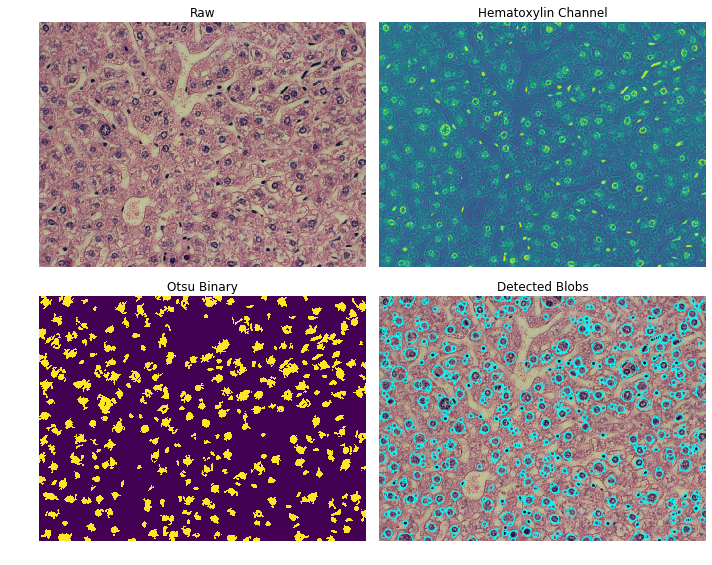

In [66]:
image = r'/Users/kenxiong/Documents/BMI260/Final Project/data/1M_AL_Female/AMC-145/AMC-145--001-macurato.tif'

show = get_section_features(image, geo_features, tex_features, demo=True)


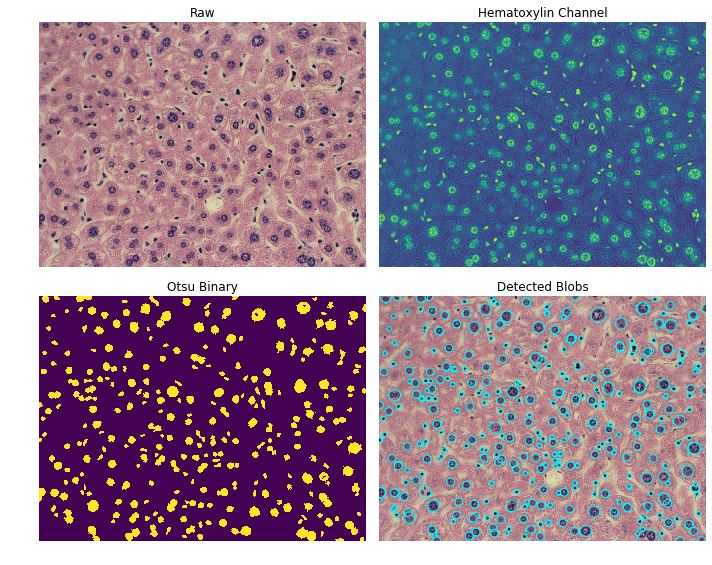

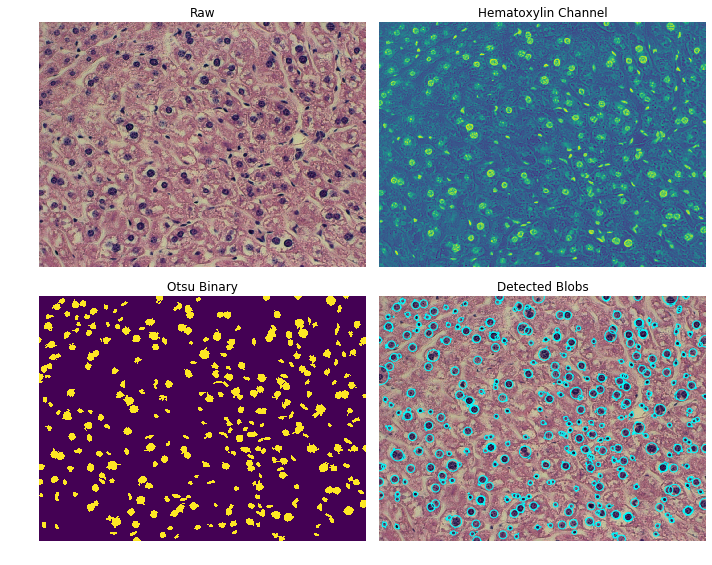

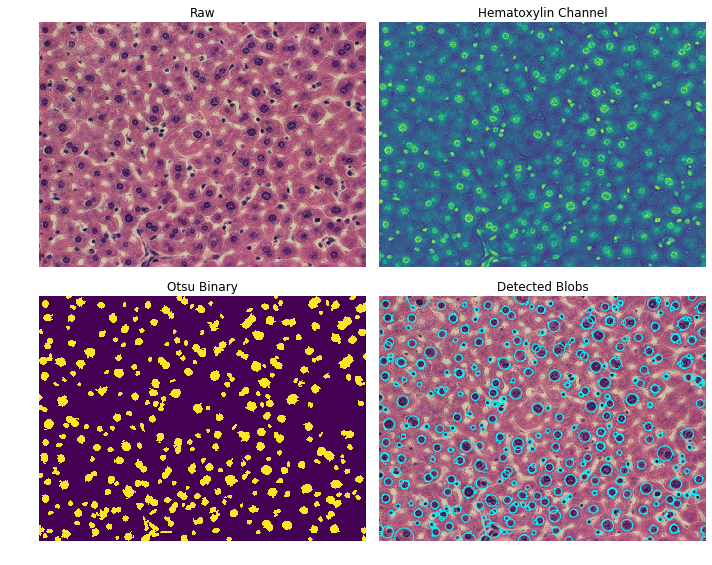

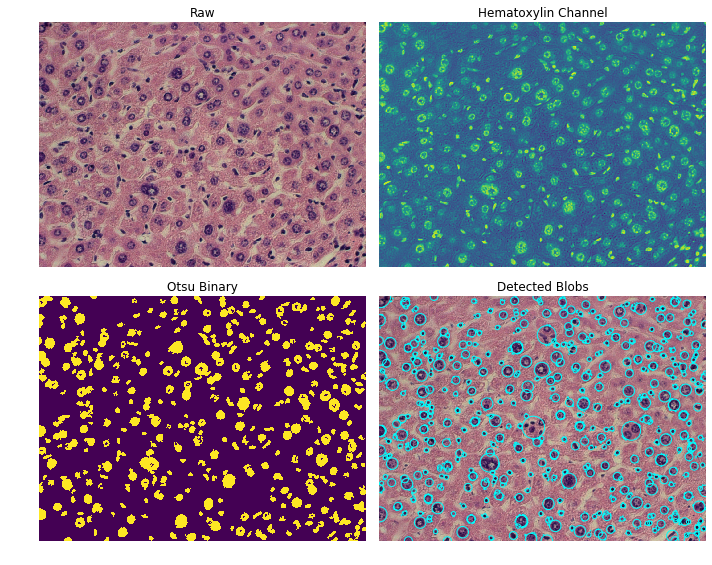

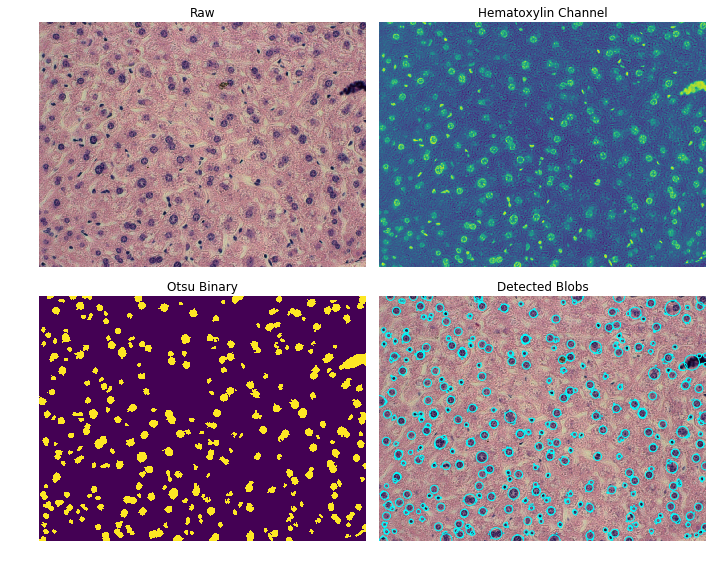

In [67]:
sample_indices = random.sample(range(df.shape[0]), 5)
sample_paths = df.loc[sample_indices, 'File Path']

for path in sample_paths:
    sample_feats = get_section_features(path, geo_features, tex_features, demo=True)

In [250]:
feature_set = geo_features + tex_features + ['Region Count']

In [252]:
section_features = []

for index, row in df.iterrows():
    image = row['File Path']
    section_features.append(get_section_features(image, geo_features, tex_features))
    
    if index > 0 and np.mod(index, 100) == 0:
        print(index, 'images down.')
        df_ft = pd.DataFrame(section_features, columns=feature_set)
        df_partial = df.loc[:index, :]
        df_progress = df_partial.join(df_ft)
        progress_path = root + r'/blob_data_' + str(index) + r'.csv'
        df_progress.to_csv(progress_path)
        
# save everthing together        
df_ft = pd.DataFrame(section_features, columns=feature_set)
df_complete = df.join(df_ft)
save_path = root + r'/blob_data_COMPLETE.csv'
df_complete.to_csv(save_path)

ids = list(set(np.array(df.loc[:, 'Animal ID'])))
t_and_v, test_ids = train_test_split(ids, shuffle=True, test_size=0.2, train_size=0.8)
training_ids, validation_ids = train_test_split(t_and_v, shuffle=True, test_size=0.14, train_size=0.86)

col_out = ['Sex', 'Animal ID', 'Sequence ID', 'File Path']
df_training = df_complete.loc[df['Animal ID'].isin(training_ids)].drop(columns=col_out)
df_validation = df_complete.loc[df['Animal ID'].isin(validation_ids)].drop(columns=col_out)
df_testing = df_complete.loc[df['Animal ID'].isin(test_ids)].drop(columns=col_out)

df_training.to_csv(root + r'/blob_data_TRAINING.csv')
df_validation.to_csv(root + r'/blob_data_VALIDATION.csv')
df_testing.to_csv(root + r'/blob_data_TESTING.csv')



100 images down.
200 images down.
300 images down.
400 images down.
500 images down.
600 images down.
700 images down.
800 images down.
900 images down.
1000 images down.


In [246]:
df_training

Age  area  bbox_area  convex_area  eccentricity  equivalent_diameter  \
50    1   NaN        NaN          NaN           NaN                  NaN   
51    1   NaN        NaN          NaN           NaN                  NaN   
52    1   NaN        NaN          NaN           NaN                  NaN   
53    1   NaN        NaN          NaN           NaN                  NaN   
54    1   NaN        NaN          NaN           NaN                  NaN   
55    1   NaN        NaN          NaN           NaN                  NaN   
56    1   NaN        NaN          NaN           NaN                  NaN   
57    1   NaN        NaN          NaN           NaN                  NaN   
58    1   NaN        NaN          NaN           NaN                  NaN   
59    1   NaN        NaN          NaN           NaN                  NaN   
60    1   NaN        NaN          NaN           NaN                  NaN   
61    1   NaN        NaN          NaN           NaN                  NaN   
62    1   NaN        NaN          NaN           NaN                  NaN   
63    1   NaN        NaN          NaN           NaN                  NaN   
64    1   NaN        NaN          NaN           NaN                  NaN   
65    1   NaN        NaN          NaN           NaN                  NaN   
66    1   NaN        NaN          NaN           NaN                  NaN   
67    1   NaN        NaN          NaN           NaN                  NaN   
68    1   NaN        NaN          NaN           NaN                  NaN   
69    1   NaN        NaN          NaN           NaN                  NaN   
70    1   NaN        NaN          NaN           NaN                  NaN   
71    1   NaN        NaN          NaN           NaN                  NaN   
72    1   NaN        NaN          NaN           NaN                  NaN   
73    1   NaN        NaN          NaN           NaN                  NaN   
74    1   NaN        NaN          NaN           NaN                  NaN   
75    1   NaN        NaN          NaN           NaN                  NaN   
76    1   NaN        NaN          NaN           NaN                  NaN   
77    1   NaN        NaN          NaN           NaN                  NaN   
78    1   NaN        NaN          NaN           NaN                  NaN   
79    1   NaN        NaN          NaN           NaN                  NaN   
..   ..   ...        ...          ...           ...                  ...   
897  24   NaN        NaN          NaN           NaN                  NaN   
898  24   NaN        NaN          NaN           NaN                  NaN   
899  24   NaN        NaN          NaN           NaN                  NaN   
900  24   NaN        NaN          NaN           NaN                  NaN   
901  24   NaN        NaN          NaN           NaN                  NaN   
902  24   NaN        NaN          NaN           NaN                  NaN   
903  24   NaN        NaN          NaN           NaN                  NaN   
904  24   NaN        NaN          NaN           NaN                  NaN   
905  24   NaN        NaN          NaN           NaN                  NaN   
906  24   NaN        NaN          NaN           NaN                  NaN   
907  24   NaN        NaN          NaN           NaN                  NaN   
908  24   NaN        NaN          NaN           NaN                  NaN   
909  24   NaN        NaN          NaN           NaN                  NaN   
910  24   NaN        NaN          NaN           NaN                  NaN   
911  24   NaN        NaN          NaN           NaN                  NaN   
912  24   NaN        NaN          NaN           NaN                  NaN   
913  24   NaN        NaN          NaN           NaN                  NaN   
914  24   NaN        NaN          NaN           NaN                  NaN   
915  24   NaN        NaN          NaN           NaN                  NaN   
916  24   NaN        NaN          NaN           NaN                  NaN   
917  24   NaN        NaN          NaN           NaN 